In [1]:
import pandas as pd
import os

In [2]:
min_start_len = 5000
min_start_ratio = 0.8
max_merge_dist = 1000
dbscan_eps = 1000
min_len_after_split_strand = 1000
min_len_after_split_dbscan = 2000
min_len_after_split = 1000
graph_sim_ratio = 0.8

dset = 'part04_buffalo'
res_dir = '../results_a4/' + dset + '/'
os.makedirs(res_dir, exist_ok=True)

# preprocessing

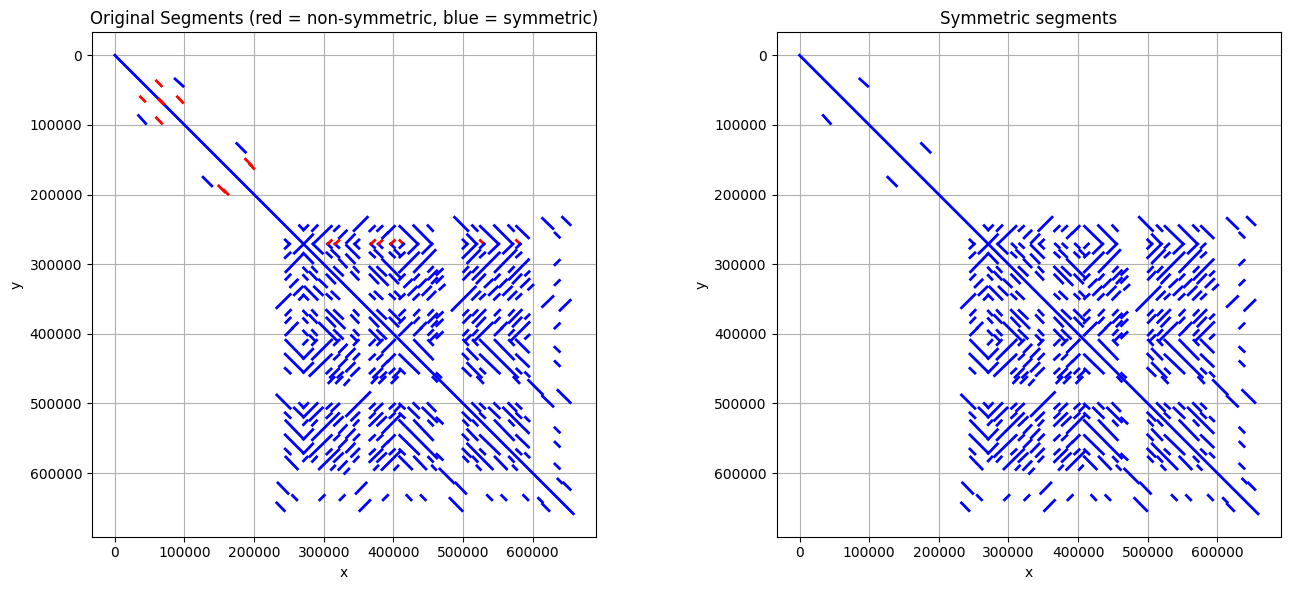

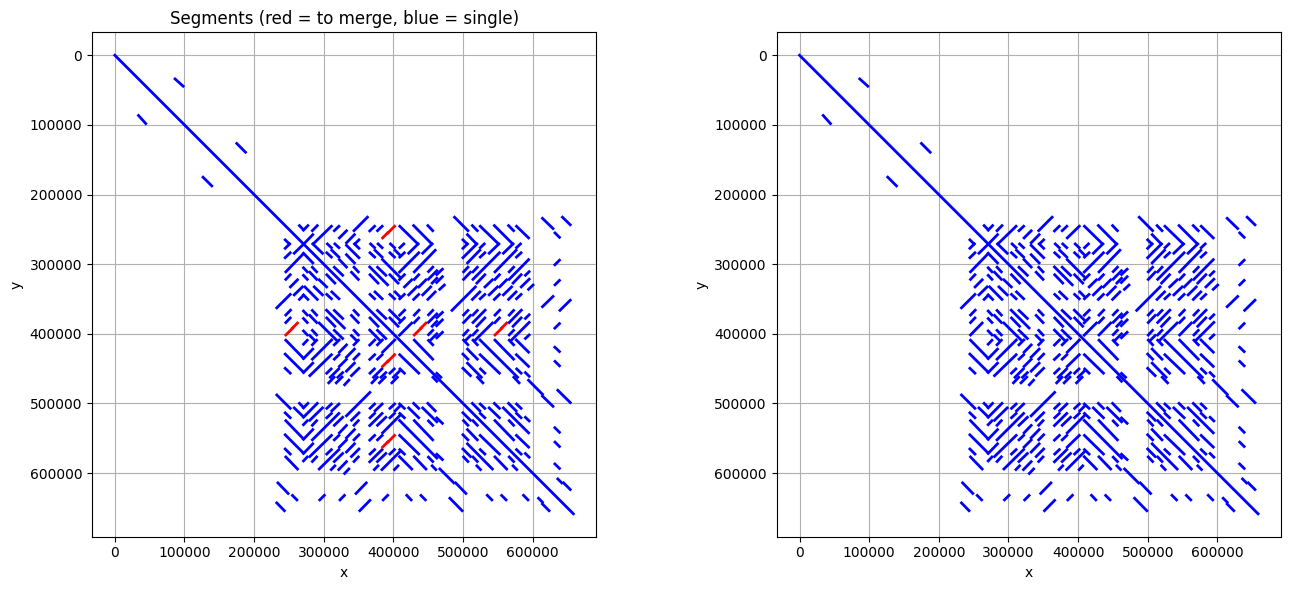

In [3]:
from importlib import reload

import utilx1
reload(utilx1)
from utilx1 import preprocess, merge_segments, symmetric

species_id = 0
species_name = 'buffalo'

df1 = pd.read_csv('../a1_fasta/patchwork_output_buffalo_part4/pairwise_alignments/self_0-water_buffalo_unknown.tsv', sep='\t')
df2 = preprocess(df1, min_start_len, min_start_ratio)
df3 = symmetric(df2, plot=True)
df4 = merge_segments(df3, threshold=1000, plot=True)

# negative strands

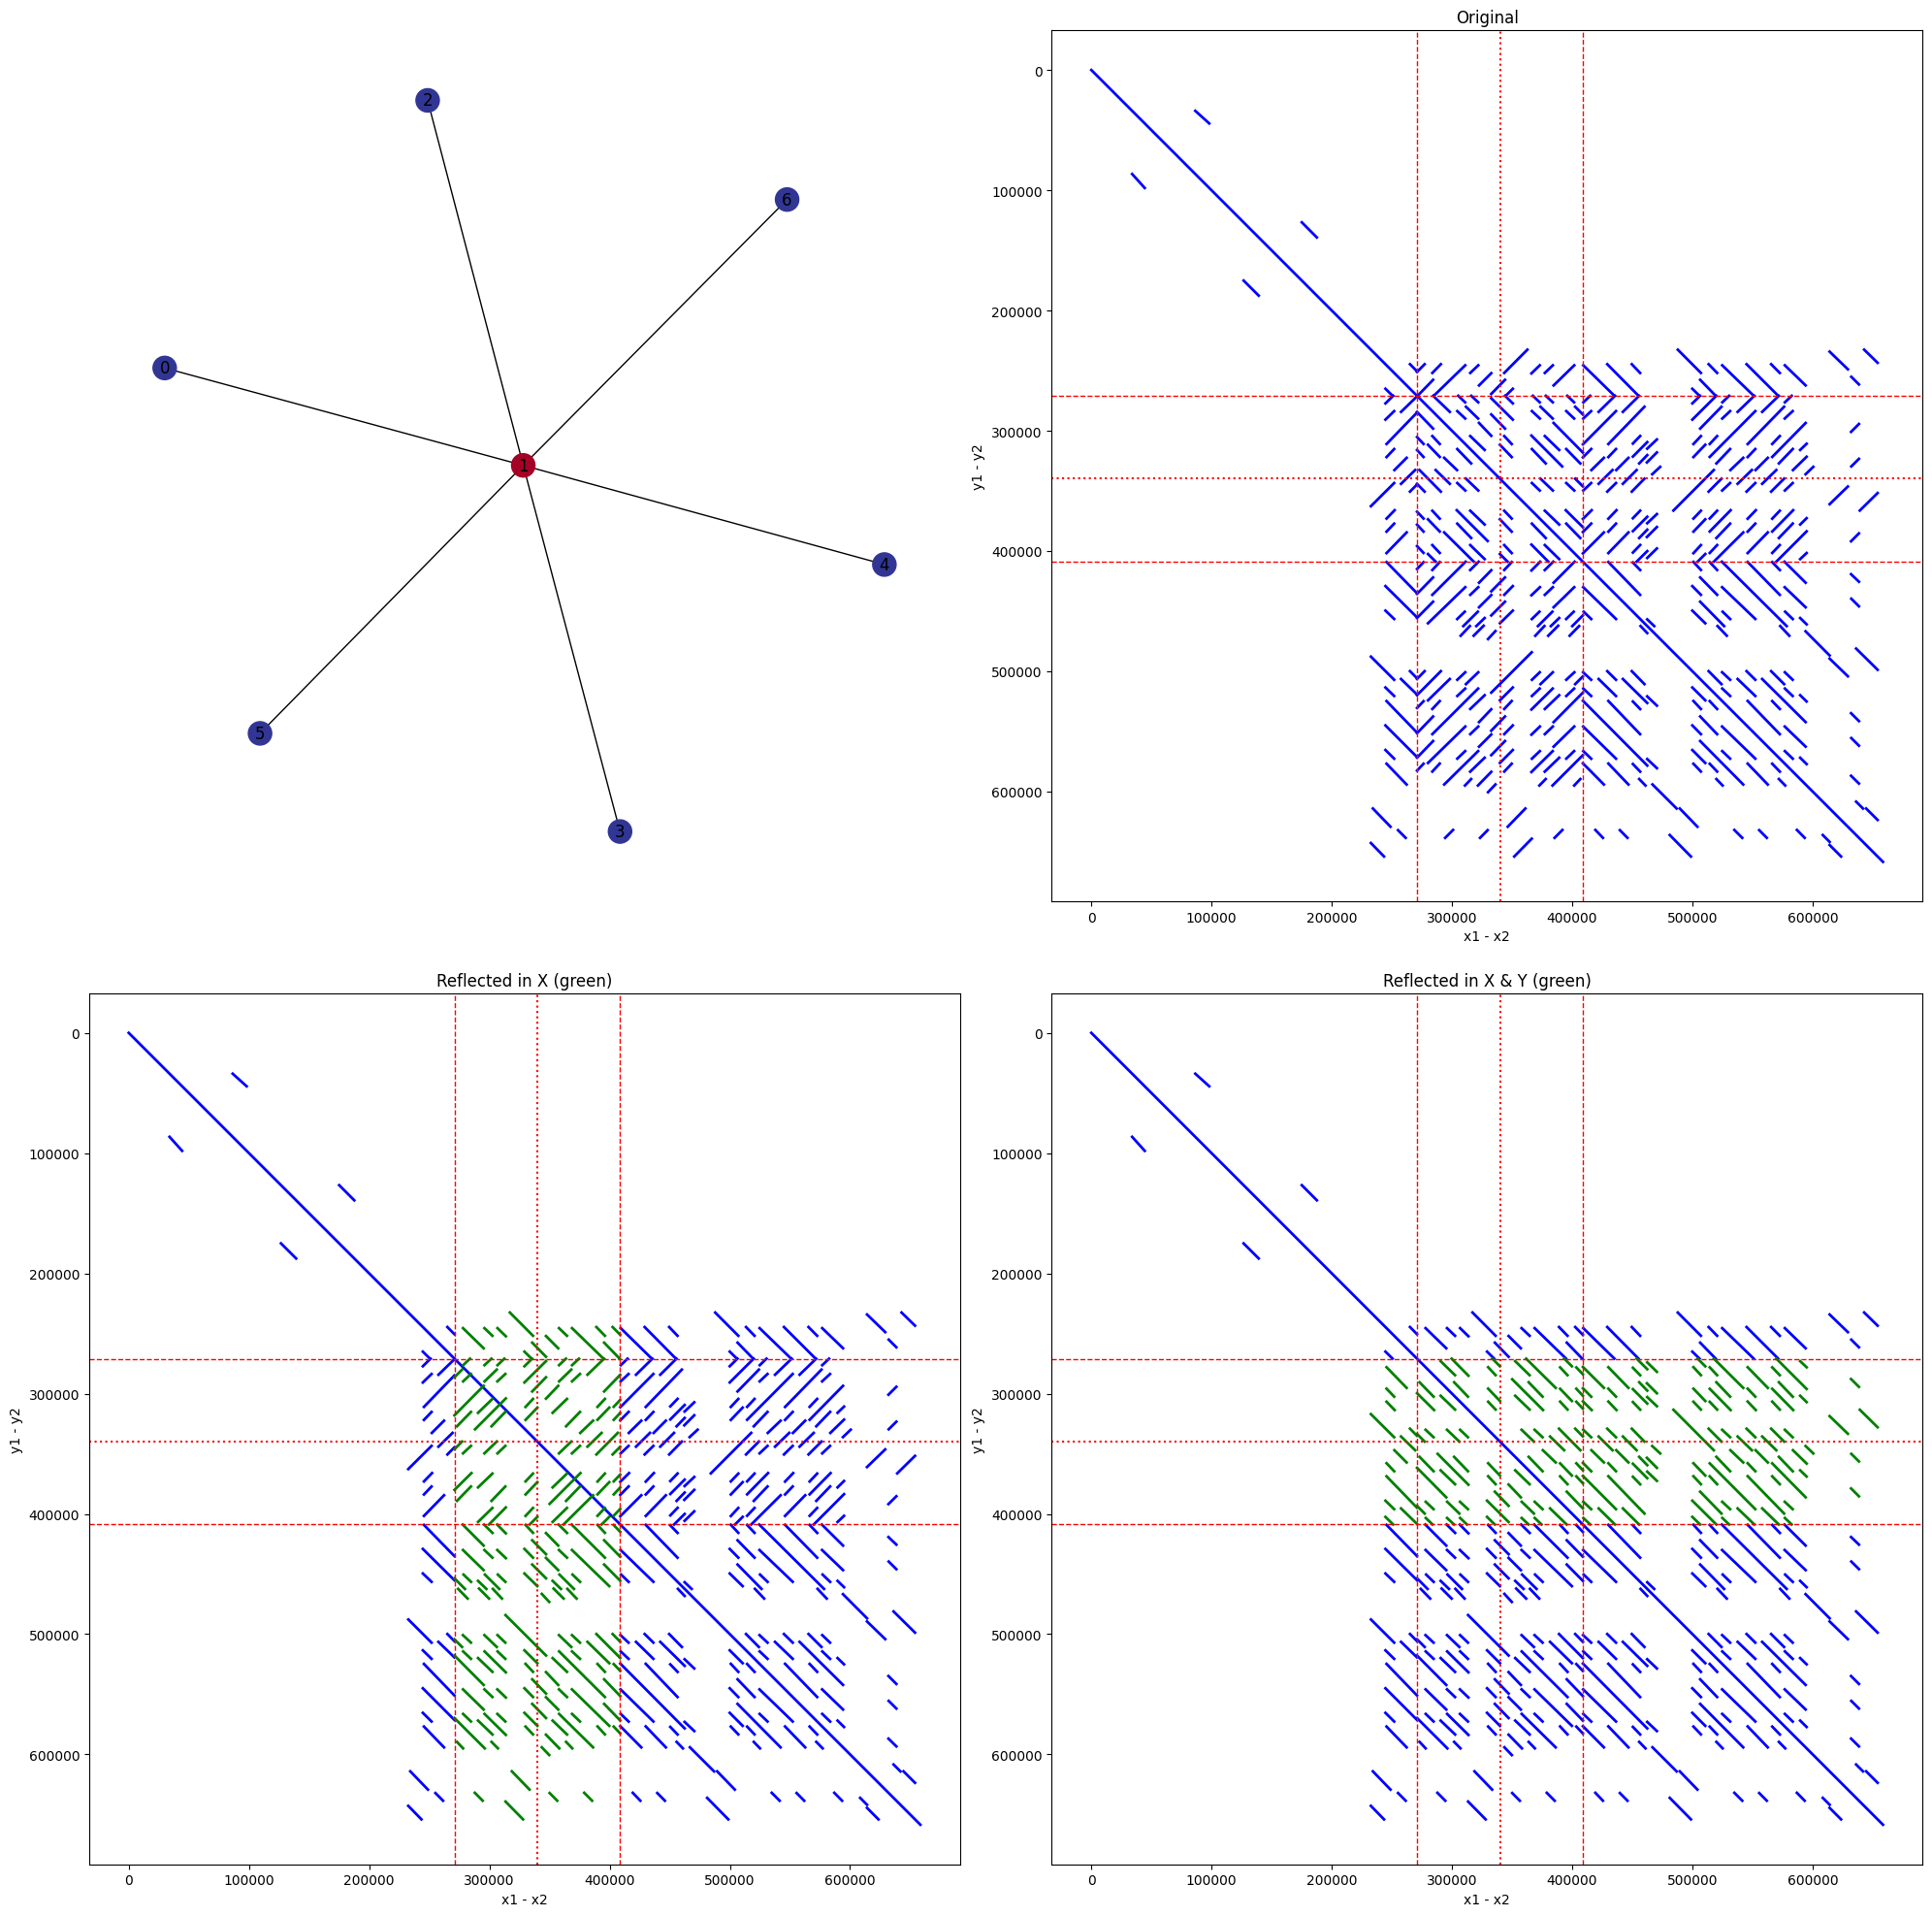

In [4]:
import utilx1
reload(utilx1)
from utilx1 import find_negative_sites, find_negative_set, reflect_segments_with_visuals

df5, df5_sites = find_negative_sites(df4)
negative_dict = find_negative_set(df5, df5_sites, plot=False)
df6 = reflect_segments_with_visuals(pd.concat([df5, df4[df4.strand2=='+']]), negative_dict)

# necklace

## найти отрезки с близкими проекциями начала или конца (разбить на кластеры), разрезать отрезки по этим границам

In [5]:
import utilx2
reload(utilx2)
from utilx2 import find_split_points_dbscan, split_segments_by_values, loop, make_fig

split_points = find_split_points_dbscan(df6, dbscan_eps)

df7 = split_segments_by_values(df6, split_points_x = split_points, split_points_y = split_points, min_length = min_len_after_split_dbscan)

split_points = list(df7.x1) + list(df7.x2)
df7, df8, connected_components = loop(df7, split_points, min_len_after_split, graph_sim_ratio)

while len(connected_components)>0:
    merged_list = [item for component in connected_components for item in component]
    df9 = df8[df8.cluster.isin(merged_list)]
    split_points = list(df9.x1) + list(df9.x2)
    df7, df8, connected_components = loop(df7, split_points, min_len_after_split, graph_sim_ratio)


Number of clusters: 15


In [6]:
df10 = negative_dict['negative_sites'][['x1_m', 'x2_m']].copy()
df10.columns = ['x1', 'x2']
df10['role'] = 'reverse_region'
df10['cluster'] = -1
df10['reverse'] = True

In [7]:
dfw1 = df4.sort_values(by=['x1', 'x2'])
dfw1['role'] = 'segment'
dfw2 = df6.sort_values(by=['x1', 'x2'])[['seq_id', 'x1', 'y1', 'x2', 'y2', 'strand2']]
dfw2['role'] = 'segment_reflected'
dfw = pd.concat([dfw1, dfw2]).reset_index(drop=True)
#dfw.to_csv(res_dir+speciex1+'_segments.tsv', sep='\t', index=None)

dfw_clusters = pd.concat([df8, df10]).reset_index(drop=True)
dfw_clusters = dfw_clusters[['role', 'x1', 'x2', 'cluster', 'reverse']]
# dfw_clusters.to_csv(res_dir+speciex1+'_clusters.tsv', sep='\t', index=None)


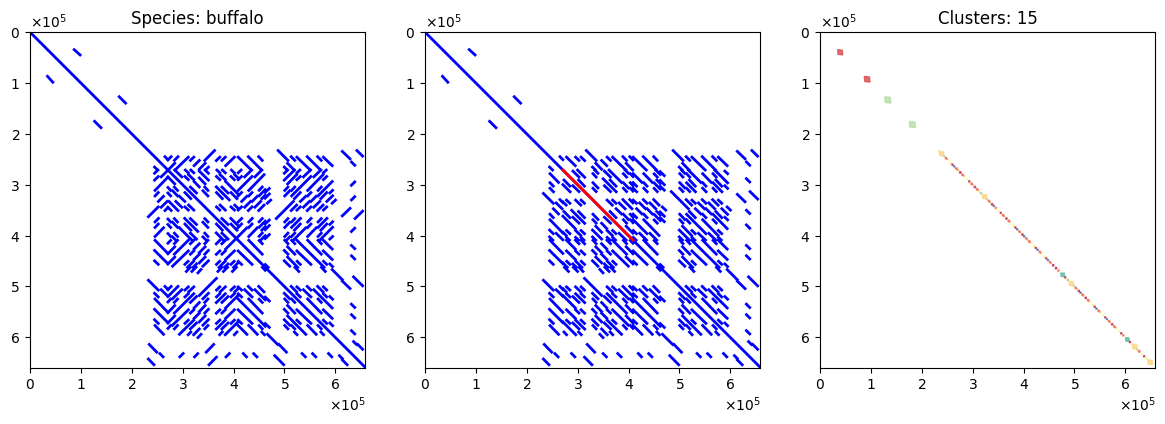

In [8]:
import utilx2
reload(utilx2)
from utilx2 import find_split_points_dbscan, split_segments_by_values, loop, make_fig, plot_necklace

make_fig(df4, df6, df8, df10, res_dir, species_name)


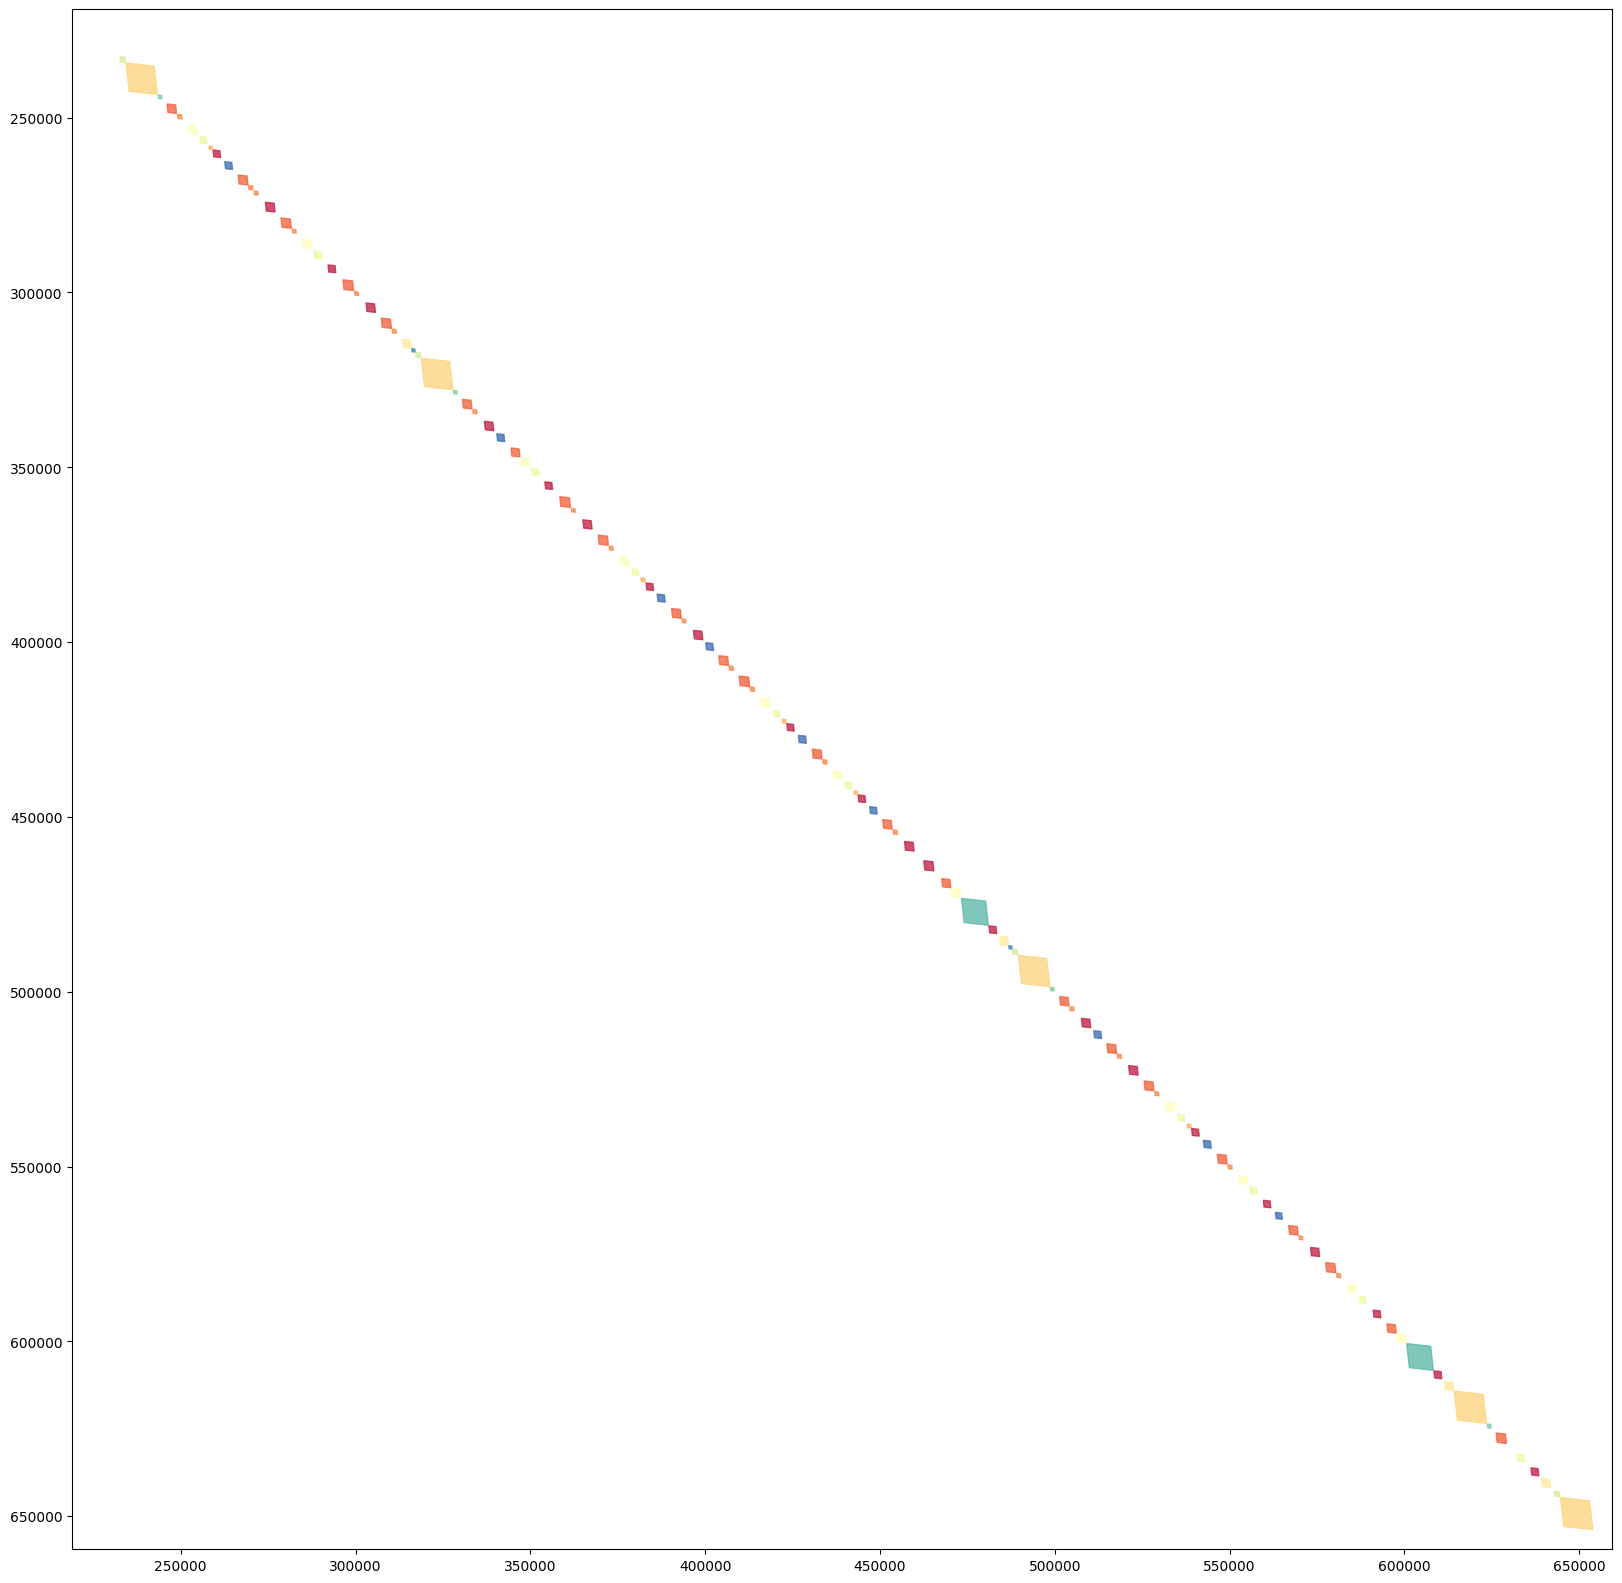

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

colors = plot_necklace(ax, df8, s_min = 220000, e_max = df4.x2.max())


In [10]:
print(dfw.head())
print(dfw.tail())

   seq_id        x1        y1        x2        y2 strand2     role
0       0       1.0       1.0  658476.0  658476.0       +  segment
1       1   33968.0   86481.0   44420.0   98093.0       +  segment
2       8   86481.0   33968.0   98093.0   44420.0       +  segment
3      10  126670.0  175082.0  139231.0  187600.0       +  segment
4      13  175082.0  126670.0  187600.0  139231.0       +  segment
     seq_id        x1        y1        x2        y2 strand2               role
781     197  636153.0  608406.0  641861.0  614103.0       +  segment_reflected
782     198  636153.0  481125.0  654015.0  498726.0       +  segment_reflected
783     417  639214.0  313416.0  654015.0  327977.0       -  segment_reflected
784     199  642817.0  232543.0  654015.0  243465.0       +  segment_reflected
785     200  644469.0  614099.0  654015.0  623606.0       +  segment_reflected


In [11]:
print(dfw_clusters.head())
print(dfw_clusters.tail())

  role        x1         x2  cluster reverse
0  NaN   33968.0   44419.50        1     NaN
1  NaN   86481.0   98092.50        1     NaN
2  NaN  126670.0  139230.50        4     NaN
3  NaN  175082.0  187599.50        4     NaN
4  NaN  232590.0  234191.75        7     NaN
               role             x1             x2  cluster reverse
121             NaN  636153.416667  638493.666667       15     NaN
122             NaN  639224.000000  641854.250000       22     NaN
123             NaN  642906.750000  644472.000000        7     NaN
124             NaN  644535.000000  654013.200000        8     NaN
125  reverse_region  270941.000000  408795.000000       -1    True
